# Conformal prediction for classification

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from mapie.classification import MapieClassifier

<div align="justify">

Conformal prediction ({cite:t}`vovk_al,shaf_at08,bala_cp`) is a framework for reliable prediction that is rooted in classical frequentist statistics, more specifically in hypothesis testing[^revision].
Given a sequence of training observations and a new query $\vec{x}_{N+1}$ (which we denoted by $\vec{x}_{q}$ before and in the following plot is marked red) with unknown outcome $y_{N+1}$,

$$
(\vec{x}_1, y_1), \,  (\vec{x}_2, y_2), \ldots ,  (\vec{x}_N, y_N), \, (\vec{x}_{N+1}, \bullet)
\enspace ,
$$(cpseq)

[^revision]: If this concept is new to you we recommend visiting our site on Hypothesis Testing {doc}`hypothesis-excurs`.

</div>

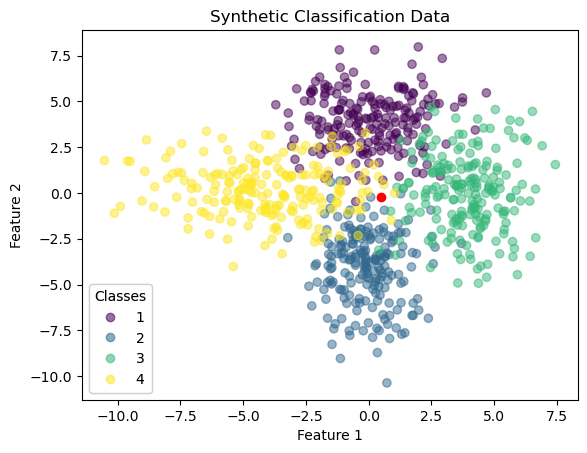

In [66]:
n_samples = 200
n_classes = 4
classes = list(range(1,n_classes+1))
random_state = 41

# parameters for toy data
means = [(0,4),(0,-4),(4,0),(-4,0)]
covs = [np.eye(2)*2.5,np.diag([1.5,3.5]), np.diag([1.5,4.5]), np.diag([5,2])]

epsilon = 0.05 # This choice is the central point of conformal prediction

np.random.seed(random_state)

X = np.vstack([
    np.random.multivariate_normal(mean,cov,n_samples) 
    for mean,cov in zip(means,covs)
])
y = np.hstack([np.full(n_samples,i) for i in classes])

x_new = np.array([0.5, -0.2])

fig, ax = plt.subplots()

ax.set_title("Synthetic Classification Data")

scatter = ax.scatter(X[:, 0], X[:, 1], c=y,alpha=.5)
ax.scatter(*x_new, c="r")

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(legend1)

ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
plt.show()

<div align="justify">

the basic idea is to hypothetically replace $\bullet$ by each candidate, i.e., to test the hypothesis $y_{N+1} = y$ for all $y \in \mathcal{Y}$. Only those outcomes $y$ for which this hypothesis can be rejected at a predefined level of confidence are excluded, while those for which the hypothesis cannot be rejected are collected to form the prediction set or *prediction region* $Y^\epsilon \subseteq \mathcal{Y}$. The construction of a set-valued prediction $Y^\epsilon = Y^\epsilon(\vec{x}_{n+1})$ that is guaranteed to cover the true outcome $y_{N+1}$ with a given probability $1- \epsilon$ (for example 95\,\%), instead of producing a point prediction $\hat{y}_{N+1} \in \mathcal{Y}$, is the basic idea of conformal prediction. Here, $\epsilon \in (0,1)$ is a pre-specified level of significance. In the case of classification, $Y^\epsilon$ is a subset of the set of classes $\mathcal{Y} = \{ y_1, \ldots , y_K \}$, whereas in regression, a prediction region is commonly represented in terms of an interval[^regressionCase].

[^regressionCase]: Obviously, since $\mathcal{Y} = \mathbb{R}$ is infinite in regression, a hypothesis test cannot be conducted explicitly for each candidate outcome $y$. 
</div>

<div align="justify">

Hypothesis testing is done in a nonparametric way: Consider any ''nonconformity'' function $f: \, \mathcal{X} \times \mathcal{Y} \longrightarrow \mathbb{R}$ that assigns scores $\alpha = f(\vec{x}, y)$ to input/output tuples; the latter can be interpreted as a measure of ''strangeness'' of the pattern $(\vec{x}, y)$, i.e., the higher the score, the less the data point $(\vec{x}, y)$ conforms to what one would expect to observe.
```{note}
The error bounds are valid and well calibrated by construction, regardless of the nonconformity function $f$. However, the choice of this function has an important influence on the *efficiency* of conformal prediction, that is, the size of prediction regions: The more suitable the nonconformity function is chosen, the smaller these sets $Y^\epsilon$ will be. 
```

An example of a nonconformity score based on nearest neighbors:

$$
f(\vec{x},y) = \frac{\sum_{i=1}^k d_i^+}{\sum_{i=1}^k d_i^-}
$$

where $d_i^+$ is the distance from the $i^{th}$ nearest neighbor labeled y, and $d_i^-$ the distance from the $i^{th}$ nearest neighbor labeled differently.
Applying this function to the sequence {eq}`cpseq`, with a specific (though hypothetical) choice of $y = y_{N+1}$ (let us pick y = 1), yields a sequence of scores

$$
\alpha_1, \, \alpha_2, \ldots , \alpha_N , \, \alpha_{N+1} \enspace .
$$

</div>

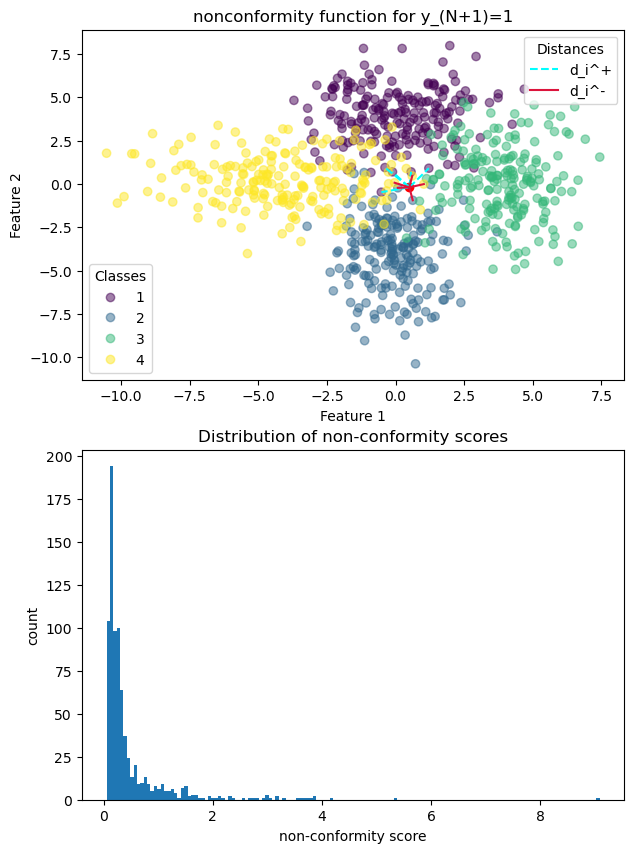

In [67]:
def euclidean_distance(x, data):
    dist = np.linalg.norm(
        x - data, axis=1, ord=2
    )  # L2-norm (euclidean distance between x and all data points in X)
    return dist


def nearest_neighbors_idx(distances, k=5):
    idx = np.argpartition(
        distances, k
    )  # makes the kth element as pivot such that left from it are all smaller elements
    return idx[:k]


def nearest_neighbors_distance(x, data, k=5):
    dist = euclidean_distance(x, data)
    idx = nearest_neighbors_idx(dist, k)
    return dist[idx]  # get the distances of the k nearest neighbors


def split_data_classes(y_i, X, y):
    # create two datasets one where each point has the same class as y_i the other points in the second dataset.
    mask_same_class = y == y_i
    data_with_same_class = X[mask_same_class, :]
    data_with_other_class = X[~mask_same_class, :]
    return data_with_same_class, data_with_other_class


def nearest_neighbors_non_conformity_function(x_i, y_i, X, y):
    data_with_same_class, data_with_other_class = split_data_classes(y_i, X, y)
    distance_to_same_class = np.sum(
        nearest_neighbors_distance(x_i, data_with_same_class, k=5)
    )
    distance_to_other_class = np.sum(
        nearest_neighbors_distance(x_i, data_with_other_class, k=5)
    )

    return distance_to_same_class / distance_to_other_class


def get_nonconformityScores(x_new, y_new):
    data = np.concatenate((X, y.reshape(-1, 1)), axis=1)  # merge X and y into one array
    new_point = np.hstack((x_new, y_new))  # make the new data point
    complete_data = np.vstack((data, new_point))  # put all together

    resulting_scores = np.array(
        [
            nearest_neighbors_non_conformity_function(
                x_i=complete_data[i, :-1],
                y_i=complete_data[i, -1],
                X=np.delete(complete_data, i, axis=0)[:, :-1],
                y=np.delete(complete_data, i, axis=0)[:, -1],
            )
            for i in range(complete_data.shape[0])
        ]
    )

    return resulting_scores


def plot_nearest_neighbors_distance(y_new, ax):
    ax.set_title(f"nonconformity function for y_(N+1)={y_new}")

    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, alpha=.5)
    ax.scatter(*x_new, c="red")

    # look up other colors: https://en.wikipedia.org/wiki/X11_color_names
    # visualize the distance to the equally labeled points:
    data_with_same_class, data_with_other_class = split_data_classes(y_new, X, y)
    for i in nearest_neighbors_idx(
        euclidean_distance(x_new, data_with_same_class), k=5
    ):
        x_values = [x_new[0], data_with_same_class[i, 0]]
        y_values = [x_new[1], data_with_same_class[i, 1]]
        (line1,) = ax.plot(
            x_values, y_values, linestyle="--", c="Aqua", label="d_i^+"
        )

    # visualize the distance to the differently labeled points:
    for i in nearest_neighbors_idx(
        euclidean_distance(x_new, data_with_other_class), k=5
    ):
        x_values = [x_new[0], data_with_other_class[i, 0]]
        y_values = [x_new[1], data_with_other_class[i, 1]]
        (line2,) = ax.plot(
            x_values, y_values, linestyle="-", c="crimson", label="d_i^-"
        )

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
    ax.add_artist(legend1)

    # produce a legend with the distance
    ax.legend(handles=[line1, line2], loc="upper right", title="Distances")

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

def plot_non_conformity_scores(non_conformity_scores, ax):
    ax.set_title("Distribution of non-conformity scores")
    
    ax.hist(non_conformity_scores,bins="auto")
    
    ax.set_xlabel("non-conformity score")
    ax.set_ylabel("count")
alpha_values_y1 = get_nonconformityScores(x_new=x_new, y_new=1)

fig, ax = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches((7,10))
plot_nearest_neighbors_distance(y_new=1, ax=ax[0])
plot_non_conformity_scores(alpha_values_y1,ax=ax[1])
# plot_nearest_neighbors_distance(y_new=1, ax=ax)
# plot_nearest_neighbors_distance(y_new=2, ax=ax)
# plot_nearest_neighbors_distance(y_new=3, ax=ax)
plt.show()

<div align="justify">

Denote by $\sigma$ the permutation of $\{1, \ldots , N+1\}$ that sorts the scores in increasing order, i.e., such that $\alpha_{\sigma(1)} \leq \ldots \leq \alpha_{\sigma(N+1)}$. Under the assumption that the hypothetical choice of $y_{N+1}$ is in agreement with the true data-generating process, and that this process has the property of exchangeability (which is weaker than the assumption of independence and essentially means that the order of observations is irrelevant), every permutation $\sigma$ has the same probability of occurrence. Consequently, the probability that $\alpha_{N+1}$ is among the $\epsilon$\,\% highest nonconformity scores should be low. This notion can be captured by the $p$-values associated with the candidate $y$, defined as 

$$
p(y)   := \frac{\# \{ i \given \alpha_i \geq \alpha_{N+1} \}}{N+1}
$$(probability_y_highestNonConformity)

</div>

In [68]:
def calculate_probability(nonconformity_sequence):
    # calculate the proportion that at least new data points nonconformity score occurs.
    new_datapoint_nonconformityScore = nonconformity_sequence[-1]
    probability = np.sum(
        nonconformity_sequence >= new_datapoint_nonconformityScore
    ) / len(
        nonconformity_sequence
    )  # the N + 1 is inherently in the length of the sequence
    return probability

probability_y1 = calculate_probability(alpha_values_y1)
print("Probability of y = 1: ", probability_y1)

Probability of y = 1:  0.03870162297128589


<div align="justify">

According to what we said, the probability that $p(y) < \epsilon$ (i.e., $\alpha_{N+1}$ is among the $\epsilon$\,\% highest $\alpha$-values) is upper-bounded by $\epsilon$. 
Thus, the hypothesis $y_{N+1} = y$ can be rejected for those candidates $y$ for which $p(y) < \epsilon$. 
For the initial choice y = 1 we can reject this candidate, because $p(y) \approx 0.038 < 0.05 = \epsilon$.
The complete $Y_\epsilon$ can then be constructed iterating through all possible candidates $y = y_{N+1}$. 

</div>

In [69]:
probabilities = {possible_class: calculate_probability(get_nonconformityScores(x_new, possible_class))
                 for possible_class in classes}

Y_epsilon = set(
    [
        prediction
        for prediction,probability in probabilities.items()
        if probability >= 0.05
    ]
)
print("Prediction set Y:", Y_epsilon)

Prediction set Y: {2, 4}


<div align="justify">

Conformal prediction as outlined above realizes transductive inference, although inductive variants also exist ({cite:t}`papa_ic08`). For transductive inference the non-conformity scores $\alpha_1, \, \alpha_2, \ldots , \alpha_N , \, \alpha_{N+1}$ have to re-calculated for each new proposal $y_{N+1}=y$. In inductive inference this problem is solved by using an *calibration* dataset. Many packages have already been published implementing the inductive inference, such as [MAPIE](https://mapie.readthedocs.io/en/latest/index.html). We again use the above mentioned synthetic dataset and split it into $l$ training, $N-l$ testing points.

</div>

In [70]:
X_train,X_val,y_train,y_val = train_test_split(X,
                                             y,
                                             train_size=0.8,
                                             random_state=random_state)

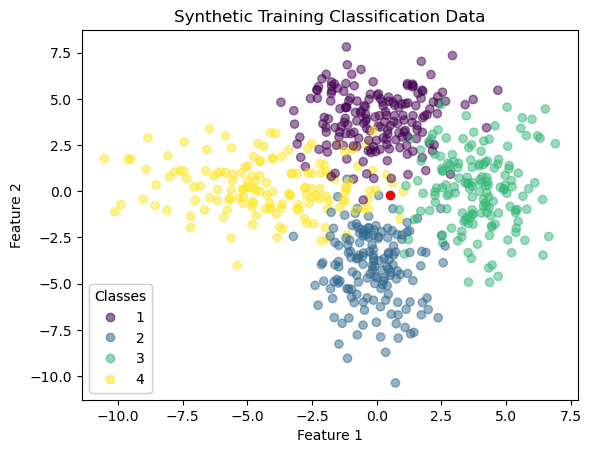

In [71]:
fig, ax = plt.subplots()

ax.set_title("Synthetic Training Classification Data")

scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=.5)
ax.scatter(*x_new, c="r")

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(legend1)

ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
plt.show()

<div align="justify">

In the next step we take an arbitrary classifier such as the [Gaussian Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html) and train it on the classification dataset. Then on the validation dataset the corresponding non-conformity scores are computed for which we use the wrapper [MapieClassifier](https://mapie.readthedocs.io/en/latest/generated/mapie.classification.MapieClassifier.html#mapie.classification.MapieClassifier). For this a corresponding non-conformity function $f$ has to be defined. 
We will use the *Least Ambiguous Set-Valued Classifier* (LAC) method from {cite:t}`LAC_Method`.

$$
    f(\vec{x},y) = 1 - \hath(\vec{x})_y
$$

where $\hath$ is a classifier and $\hath(x)_y$ the probability of classifying the data point $x$ as $y$. 
Applying this function to the validation dataset yields a sequence of non-conformity scores $\alpha_{l+1}, \, \alpha_{l+2}, \ldots , \alpha_{N-1}, \alpha_{N}$ which can be represented by the below Histogram.

</div>

```{note}
From an usage aspect is not necessary to split the data into train and validation beforehand. 
The *MapieClassifier* would do this automatically controlled by the parameter `cv`. 
Here we want to illustrate therefore we choose `cv="prefit"`
```

In [72]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train,y_train)

conformal_classifier = MapieClassifier(naive_bayes,
                                       method="lac",
                                       cv="prefit", 
                                       random_state=random_state)
conformal_classifier.fit(X_val,y_val)

non_conformity_scores = conformal_classifier.conformity_scores_

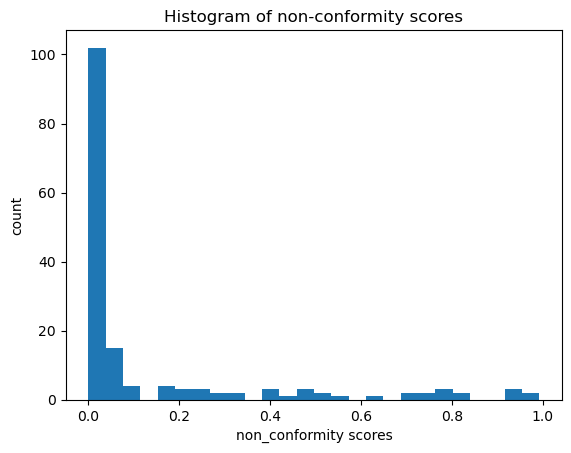

In [73]:
# Plot the score distribution
fig, ax = plt.subplots()
ax.hist(non_conformity_scores, bins="auto")

ax.set_title("Histogram of non-conformity scores")
ax.set_xlabel("non_conformity scores")
ax.set_ylabel("count")

plt.show()

<div align="justify">

Now given a $\epsilon$ one can define based on the above distribution an threshold $q$ such that all candidates $y_{N+1}=y$ can be rejected if $f(x_{N+1},y_{N+1}) \geq q$. The value of $q$ is chosen such that {eq}`probability_y_highestNonConformity` holds. The resulting prediction set is as follows:

$$
    Y^\epsilon = \{
            y \given 1 - \hath(x_{N+1})_y \leq q
        \}
$$

To calculate $q$ one must think of a value such that $(1-\epsilon)$\% of the non-conformity scores $\alpha_{l+1}, \, \alpha_{l+2}, \ldots , \alpha_{N-1}, \alpha_{N}$ are smaller then $q$. 
This is exactly what the $(1-\epsilon)$ quantile represents!
Therefore to have our threshold q we calculate the $\frac{\lceil (N-l+1)*(1-\epsilon) \rceil}{n}$ quantile on the sequence $\alpha_{l+1}, \, \alpha_{l+2}, \ldots , \alpha_{N-1}, \alpha_{N}$:

$$
    q = \textit{Quantile}\left(\alpha_{l+1}, \, \alpha_{l+2}, \ldots , \alpha_{N-1}, \alpha_{N}, \frac{\lceil (N-l+1) (1-\epsilon) \rceil}{N-l}\right)
$$ 

We use $(N-l+1)$ instead of $(N-l)$ to take into account the finite sample size.

</div>

In [74]:
# helper function converting the mapie output to a "real" prediction set
def to_predictionSet(prediction_set_indicator):    
    n_samples, n_classes, n_alpha = prediction_set_indicator.shape

    prediction_sets_with_zero_fills = prediction_set_indicator * np.array(classes)[None, :, None]

    datapoint_sets = [[]] * n_alpha # we need so many prediction sets for each data point as we defined alpha values
    prediction_sets =[datapoint_sets] * n_samples
    for sample in range(n_samples):
        for epsilon in range(n_alpha):
            current_mask = (
                prediction_sets_with_zero_fills[sample, :, epsilon] > 0
            )  # mask to indicate the classes included in set
            prediction_sets[sample][epsilon] = set(prediction_sets_with_zero_fills[
                sample, :, epsilon
            ][
                current_mask
            ])  # put these values in the prediction set
    return prediction_sets

In [75]:
point, prediction_set_indicator = conformal_classifier.predict(
    x_new.reshape(1, -1),
    alpha=[0.05, 0.1],  # note that what we denote as epsilon is called alpha in MAPIE. Also we can use mutliple epsilon values
) 
print("Point estimate: ", point)
print(
    "Prediction Indicator Set(epsilon=0.05; epsilon=0.1): \n", prediction_set_indicator
)  # The output indicates whether the corresponding class is contained in the set prediction set for the given epsilon niveau.
print("Prediction sets (epsilon=.05; epsilon=0.1): \n", to_predictionSet(prediction_set_indicator=prediction_set_indicator))

Point estimate:  [2]
Prediction Indicator Set(epsilon=0.05; epsilon=0.1): 
 [[[False False]
  [ True False]
  [False False]
  [ True False]]]
Prediction sets (epsilon=.05; epsilon=0.1): 
 [[{2, 4}, set()]]


To reproduce the above output one can retrace the individual steps.
The first step is to calculate the quantile q.

In [76]:
def calculate_quantile(non_conformity_scores, epsilon):
    return np.quantile(
        non_conformity_scores,
        q=((len(non_conformity_scores) + 1) * (1 - epsilon))
        / len(non_conformity_scores),
        method="higher",  # rounds the quantile to the upper value
    )

# compute the threshold q such that only 5% proportion of the data is bigger than q

q_5percent = calculate_quantile(non_conformity_scores, 0.05)
print("Threshold with epsilon=0.05: ", q_5percent)

q_10percent = calculate_quantile(non_conformity_scores, 0.1)
print("Threshold with epsilon=0.10: ", q_10percent)

Threshold with epsilon=0.05:  0.7831678438712201
Threshold with epsilon=0.10:  0.5646060878125463


As for the next step we calculate the non-conformity scores for the data point $x_{N+1}$.

In [77]:
# compute non-conformity scores for the new data point x_(N+1)
non_conformity_scores_x = (1 - naive_bayes.predict_proba(x_new.reshape(1, -1))).reshape(
    -1, 1
)
# Output the to 4 decimal places rounded non-conformity scores
for i,score in enumerate (non_conformity_scores_x.flatten()):
    print(f"Non-conformity score for y={i+1}: ", round(score,4))

Non-conformity score for y=1:  0.9137
Non-conformity score for y=2:  0.5712
Non-conformity score for y=3:  0.9026
Non-conformity score for y=4:  0.6124


In the final step we construct the $Y^\epsilon$.

In [78]:
prediction_set_5percent = set([
    i + 1 for i, score in enumerate(non_conformity_scores_x) if score <= q_5percent
])
print("Prediction set for epsilon = 5%: ", prediction_set_5percent)

prediction_set_10percent = set([
    i + 1 for i, score in enumerate(non_conformity_scores_x) if score <= q_10percent
])
print("Prediction set for epsilon = 10%: ", prediction_set_10percent)

Prediction set for epsilon = 5%:  {2, 4}
Prediction set for epsilon = 10%:  set()


<div align="justify">

With its main concern of constructing valid prediction regions, conformal prediction differs from most other machine learning methods, which produce point predictions $y \in \mathcal{Y}$, whether equipped with a degree of uncertainty or not. In a sense, conformal prediction can even be seen as being orthogonal: It predefines the degree of uncertainty (level of confidence) and adjusts its prediction correspondingly, rather than the other way around. 

</div>

## Uncertainty Quantification in Conformal prediction
<div align="justify">

Although conformal prediction is mainly concerned with constructing prediction regions, the scores produced in the course of this construction can also be used for quantifying uncertainty. In this regard, the notions of *confidence* and *credibility* have been introduced ({cite:t}`gam_pa02`): Let $p_1, \ldots , p_K$ denote the $p$-values that correspond, respectively, to the candidate outcomes $y_1, \ldots , y_K$ in a classification problem.
In the transductive case the $p$-values are directly calculated, while here in the inductive we need to calculate them separately. Let us assume a $\epsilon=0.05$.

</div>

In [79]:
def get_p_values(non_conformity_scores_validation, non_conformity_scores_newPoint):
    return {
        i
        + 1: (np.sum(non_conformity_scores_validation >= score) + 1)
        / (len(non_conformity_scores_validation) + 1)
        # the +1 is for the score itself which is also part of the non-conformity score sequence in general but not in non_conformity_scores_validation
        for i, score in enumerate(non_conformity_scores_newPoint)
    }
probabilities = get_p_values(
    non_conformity_scores_validation=non_conformity_scores,
    non_conformity_scores_newPoint=non_conformity_scores_x,
)
for y,p_y in probabilities.items():
    print(f"The probability of y = {y} is p(y) = {round(p_y,3)}.")

The probability of y = 1 is p(y) = 0.037.
The probability of y = 2 is p(y) = 0.099.
The probability of y = 3 is p(y) = 0.037.
The probability of y = 4 is p(y) = 0.099.


<div align="justify">

If a definite choice (point prediction) $\hat{y}$ has to be made, it is natural to pick the $y_i$ with the highest $p$-value. The value $p_i$ itself is then a natural measure of credibility, since the larger (closer to 1) this value, the more likely the prediction is correct. Note that the value also corresponds to the largest significance level $\epsilon$ for which the prediction region $Y^\epsilon$ would be empty (since all candidates would be rejected). In other words, it is a degree to which $y_i$ is indeed a plausible candidate that cannot be excluded. Another question one may ask is to what extent $y_i$ is the unique candidate of that kind, i.e., to what extent other candidates can indeed be excluded. This can be quantified in terms of the greatest $1 - \epsilon$ for which $Y^\epsilon$ is the singleton set $\{ y_i \}$, that is, $1$ minus the second-highest $p$-value. Besides, other methods for quantifying the uncertainty of a point prediction in the context of conformal prediction have been proposed ({cite:t}`linu_rc16`). 

</div>

In [80]:
def get_pointPrediction(probabilities):
    y_hat = max(probabilities, key=probabilities.get)
    
    sorted_probabilities = sorted(probabilities.values())
    credibility, confidence = sorted_probabilities[-1], 1 - sorted_probabilities[-2]
    
    return y_hat,credibility, confidence

y_hat,credibility,confidence = get_pointPrediction(probabilities)
print("Credibility: ", round(credibility,3))
print("Confidence: ", round(confidence,3))
print("Point Prediction: ", y_hat)

Credibility:  0.099
Confidence:  0.901
Point Prediction:  2


<div align="justify">

From the above output we can deduce the model has a strong belief that it can exclude other class predictions but has low belief that 2 is the real class. The credibility can be seen as indication of epistemic uncertainty, as it indicates how good the training points are at classifying $x_{N+1}$ ({cite:t}`papa_ic08`). 
Therefore a low credibility indicates a high epistemic uncertainty.
Confidence describes to how likely it is that the prediction is the true label. With a high confidence we can assume that the model is likely to have the true prediction, where the credibility indicates the (epistemic) uncertainty the model has in its prediction.
Looking at the data point $x_{N+1}$ in the above plot, we can see that it lies in the center of each cluster such that it is intuitive to have a high uncertainty regarding the prediction of that point. 

</div>